# Lab:  Source Localization for EEG

EEG or [Electroencephalography](https://en.wikipedia.org/wiki/Electroencephalography) is a powerful tool for neuroscientists in understanding brain activity.  In EEG, a patient wears a headset with electrodes that measures voltages at a number of points on the scalp.  These voltages arise from ionic currents within the brain.  A common *inverse problem* is to estimate the which parts of the brain caused the measured response.  Source localization is useful in understanding which parts of the brain are involved in certain tasks.  A key challenge in this inverse problem is that the number of unknowns (possible locations in the brain) is much larger than the number of measurements.  In this lab, we will use LASSO regression on a real EEG dataset to overcome this problem and determine the brain region that is active under an auditory stimulus.

In addition to the concepts in the [prostate LASSO demo](./demo_prostate.ipynb) you will learn to:
* Represent responses of multi-channel time-series data, such as EEG, using linear models
* Perform LASSO and Ridge regression
* Select the regularization level via cross-validation
* Visually compare the sparsity between the solutions

We first download standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load the Data

The data in this lab is taken from one of the sample datasets in the [MNE website](https://martinos.org/mne/stable/index.html). The sample data is a recording from one subject who experienced some auditory stimulus on the left ear.    

The raw data is very large (`1.5G`) and also requires that you install the `mne` python package. To make this lab easier, I have extracted and processed a small section of the data.  The following commands will get the data from a `pickle` file `eeg_dat.p` stored remotely.

In [2]:
import cloudpickle
from urllib.request import urlopen
with urlopen("http://www.ece.ohio-state.edu/~schniter/nonpublic/eeg_dat.p") as fp:
    [X,Y] = cloudpickle.load(fp)

To understand the data, there are three key variables:
* `nt`    = number of time steps that we measure data
* `nchan` = number of channels (i.e. electrodes) measured in each time step
* `ncur`  = number of currents in the brain that we want to estimate.  

Current is measured at each brain region (called a *voxel*) in three separate directions: `x`, `y`, and `z`.  So,

    nvoxels = ncur / 3
    
The components of the `X` and `Y` matrices are:
*  `Y[i,k]` = electric field measurement on channel `i` at time `k`
*  `X[i,j]` = sensitivity of channel `i` to current `j`.

Using `X.shape` and `Y.shape` compute and print `nt`, `nchan`, `ncur` and `nvoxels`.

In [11]:
# TODO
nt = Y.shape[1]# nt = ...
ncur = X.shape[1]# ncur = ...
nchan = X.shape[0]# nchan = ...
nvoxels = ncur/3# nvoxels
print('nt=%d'%nt)
print('nchan=%d'%nchan)
print('ncur=%d'%ncur)
print('nvoxels=%d'%nvoxels)

nt=85
nchan=305
ncur=22494
nvoxels=7498


## The need for Regularization

Our goal is to estimate the currents `W` in the brain from the measurements `Y`.  We will use the linear model

    Y[i,k]  = \sum_j X[i,j]*W[j,k]+ b[k]

where `W[j,k]` is the value of current `j` at time `k` and where `b[k]` is a bias.  We can solve for the current matrix `W` via linear regression.  

Note that this model differs slightly from the linear regression model that we considered in the lectures, in the following sense. At sample index `i`, the target is a *vector* `Y[i,:]` (not a scalar `y[i]`). Thus, the regresson coefficients `W[j,:]` must also be *vectors* (rather than a scalars `w[j]`) and the bias `b[:]` must also be a *vector* (rather than a scalar `b`).  In other words, if we consider a *single* value of `k` in the above model, then we get a model like that described in the lectures, which takes the form `y[i] = \sum_j X[i,j]*w[j] + b`.  But in this lab, we have several values of `k`.

However, there is a major problem:
*  There are `nt` times `ncur` unknowns in `W`
*  There are `nt` time `nchan` measurements in `Y`
*  `ncur` is much larger than `nchan`

In other words, we have

    number of unknowns >> number of measurements
    
In this case, the least-squares solution is not unique (and the matrix we'd like to invert when computing the least-squares solution is not invertible).  We can remedy this problem using regularization.  We first try Ridge regression, and later LASSO.


## Ridge Regression

First split the data into training and test.  Use the `train_test_split` function with `test_size=0.33`.

In [12]:
# TODO
Xtr,Xts,Ytr,Yts = train_test_split(X,Y,test_size=0.33)# Xtr,Xts,Ytr,Yts = train_test_split(...) 

Use the `Ridge` regression object in `sklearn` to fit the model on the training data.  Start with a regularization weight of `alpha=1` and see how well this works.

In [13]:
# TODO
regr = Ridge(alpha=1)# regr = Ridge(...)
regr.fit(Xtr,Ytr)

Ridge(alpha=1)

Predict the values `Y` on both the training and test data.  Use the `r2_score` method to measure the `R^2` value on both the training and test.  You will see that `R^2` value is large for the training data, while it is very low for the test data.  This suggest that, with regularization weight `alpha=1`, the model is over-fitting the data.

In [15]:
# TODO
Ypred_tr = regr.predict(Xtr)
Ypred_ts = regr.predict(Xts)
rsq_tr = r2_score(Ytr,Ypred_tr)# rsq_tr = ...
rsq_ts = r2_score(Yts,Ypred_ts)# rsq_ts = ...
print('rsq_tr='+str(rsq_tr))
print('rsq_ts='+str(rsq_ts))

rsq_tr=0.568467411791326
rsq_ts=0.1959248324606437


Next, try to see if we can get a better `R^2` score using a different value of `alpha`.  In particular, use cross-validation to measure the test `R^2` for 20 `alpha` values logarithmically spaced from `10^{-2}` to `10^{2}` (use `np.logspace()`).  You can use cross-validation on the train/test split from above.  You do not need to do `K`-fold.

In [28]:
# TODO
alphas = np.logspace(-2,2,20)
rsq_ts = np.zeros(20)
for i, a in enumerate (alphas):
    regr = Ridge(alpha=a)
    regr.fit(Xtr,Ytr)
    Ypred_ts = regr.predict(Xts)
    rsq_ts[i] = r2_score(Yts,Ypred_ts)

Plot the test `R^2` vs. `alpha`.  And print the maximum test `R^2`.  You should see that the maximum test `R^2` is better, but still not very high.

maximum test R^2 = 0.21928728427292574


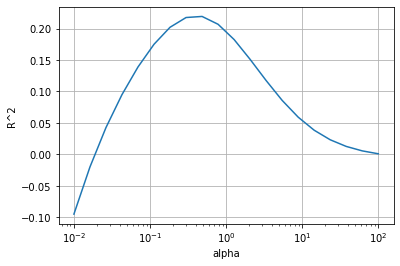

In [31]:
# TODO
plt.semilogx(alphas,rsq_ts)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.grid()
print('maximum test R^2 = '+str(max(rsq_ts)))

Now, let's take a closer look at the solution. 

* Find the optimal regularization `alpha` from the above cross-validation
* Re-fit the model using the training data and the optimal `alpha` 
* Extract the matrix `W` of linear model coefficients.  These are stored as `regr.coef_` in transposed form, so apply a transpose to get W as we defined it above
* For each current `j` compute `Wrms[j] =  sqrt( sum_k W[j,k]**2 )` which is the root mean squared value across time.

You will see that the RMS current vector `Wrms` is not sparse.  This means that the solution found by Ridge regression allows non-zero currents in all locations.

In [49]:
# TODO
imax = np.argmax(rsq_ts)
alpha = alphas[imax]
regr = Ridge(alpha=alpha)
regr.fit(Xtr,Ytr)
W = regr.coef_.T
Wrms = np.sqrt((W**2).sum(axis=0))
print(Wrms)

[42.54383698 43.09613961 43.18276063 42.93245063 42.55821356 42.28016319
 42.25151707 42.51997592 43.04146312 43.7286225  44.49640025 45.27676557
 46.00046754 46.56784564 46.83519821 46.63235374 45.81026352 44.30349763
 42.1921194  39.74724183 37.44019205 35.87245667 35.57426517 36.73128253
 39.07118581 42.03051863 45.01287584 47.54498759 49.32372963 50.21085468
 50.21174408 49.45075456 48.14356043 46.56320319 44.99701695 43.69530772
 42.82284806 42.43202114 42.47026282 42.81633432 43.32095046 43.83351677
 44.21126558 44.32268868 44.05755934 43.3496036  42.20798111 40.74517459
 39.18348842 37.82087518 36.94405306 36.71291455 37.08462585 37.84118651
 38.70314577 39.44877379 39.97926163 40.31868175 40.56457932 40.8169773
 41.12035147 41.4467813  41.72443037 41.88812157 41.92049625 41.86263833
 41.79489394 41.80315999 41.95397651 42.29062795 42.84563992 43.64841996
 44.71004234 45.98914275 47.36368908 48.636109   49.57912345 50.00387067
 49.82299139 49.08401143 47.9569336  46.67265089 45.

## LASSO Regression

We can improve the estimate by rewarding sparsity.  Biologically, we know that only a limited number of brain regions should be involved in the response to a particular stimuli.  As a result, we expect that the current matrix `W[j,k]` should be zero-valued for most locations `j` at each time `k`.  We can impose this constraint using LASSO regularization with an appropriate strength `alpha`.

Re-fit the training data using the `Lasso` model with `alpha=1e-4`.  Also set `max_iter=100` and `tol=0.01`.  The LASSO solver is much slower than Ridge regression, so this may take a minute.

In [53]:
# TODO
regr = Lasso(alpha=1e-4, max_iter=100, tol=0.01)
regr.fit(Xtr,Ytr)

Lasso(alpha=0.0001, max_iter=100, tol=0.01)

Next, evaluate the model on the test data and measure the `R^2` value.  You should get a better fit than you did with Ridge regression.  

In [54]:
# TODO
Ypred_ts = regr.predict(Xts)
rsq_ts = r2_score(Yts,Ypred_ts)
print('rsq_ts='+str(rsq_ts))

rsq_ts=0.3095122869970351


Still, the value `alpha=1e-4` was only a guess.  We should do even better with the optimal `alpha`. 

Use cross-validation (with the above test/train split) to evaluate different values of `alpha` logarithically spaced between `alpha=1e-4` and `alpha=1e-3`.  Computing each fit may take some time, so use only 5 values of `alpha`. Also, for each `alpha` you try, store the matrix `W`.  This way, you will not have to re-fit the model if you want to examine the entries of `W`.

In [55]:
# TODO
alphas = np.logspace(-4,-3,5)
rsq_ts = np.zeros(5)
W = []
for i, a in enumerate (alphas):
    regr = Lasso(alpha=a, max_iter=100, tol=0.01)
    regr.fit(Xtr,Ytr)
    Ypred_ts = regr.predict(Xts)
    rsq_ts[i] = r2_score(Yts,Ypred_ts)
    W.append(regr.coef_.T)

Plot the `R^2` value vs. `alpha`.  Print the optimal `R^2`.  You should see it is higher than with the best Ridge Regression case.

maximum test R^2 = 0.3244946622414398


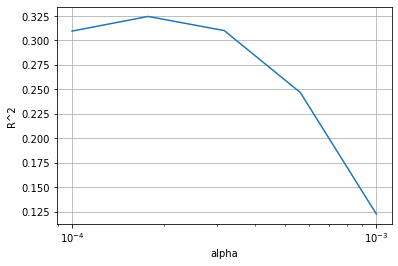

In [56]:
# TODO
plt.semilogx(alphas,rsq_ts)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.grid()
print('maximum test R^2 = '+str(max(rsq_ts)))

Display the RMS current values `Wrms` for the optimal `alpha`, as you did in the Ridge Regression case.  You will see that is much sparser.

In [59]:
# TODO
imax = np.argmax(rsq_ts)
Wrms = np.sqrt((W[imax]**2).sum(axis=0))
print(Wrms)

[ 4.22638713  4.7235765   5.20074372  5.28929284  5.32056655  5.7664149
  5.7296782   5.70530809  5.88776946  5.77243296  5.9625022   6.57507727
  7.58374252  8.60540892  9.64294049  9.39322382  9.04216833  8.95054081
  8.959643    9.4146822  10.37500699 11.6968286  13.22802314 14.50482294
 14.04853487 13.71009308 13.21446994 13.30797375 14.47825324 14.83448471
 15.52296312 15.65575106 14.85129076 14.50501967 14.23927612 13.87994763
 13.83956433 14.08794913 14.16169417 13.97575944 13.72313384 13.18528746
 12.62789846 12.0884708  11.53164001 11.0398493  10.87513018 10.02856314
  9.59450478  9.27386316  8.80559669  8.45520104  8.49281339  8.61276318
  8.36593892  8.12983957  8.03253219  7.79524354  7.70194704  7.7312232
  7.73846485  7.50672016  7.31549924  7.3396513   7.69270939  8.01921191
  8.52569352  8.77856596  8.31864201  8.6977988   8.49212103  8.41071068
  8.20742216  8.23209388  7.79509677  7.05657275  6.40023366  6.25761639
  6.36931136  6.15185816  5.58480114  5.39321176  5.3

## More fun

If you want to dive deeper into this application:
* Install the [MNE python package](https://martinos.org/mne/stable/index.html).  This is an amazing package with many tools for processing EEG data.
* In particular, you can use the above to visualize where in the brain the currents are active.
* You can also improve the fitting with better regularization.  For example, you could experiment with the combination of LASSO and ridge regression, known as ElasticNet.  There is a regression object for this in sklearn.linear_model.
* We could also use a more sophisticated regularization technique called Group LASSO, that encourages *entire rows* of the `W` matrix to be zero-valued.  This is appropriate in this application because, if the current is zero for one time, it is likely to be zero for all time. 
* You can even use the recovered current patterns to make predictions about what the patient is seeing or hearing or thinking!  It sounds like science-fiction, but it has been demonstrated to work to a certain extent!